# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


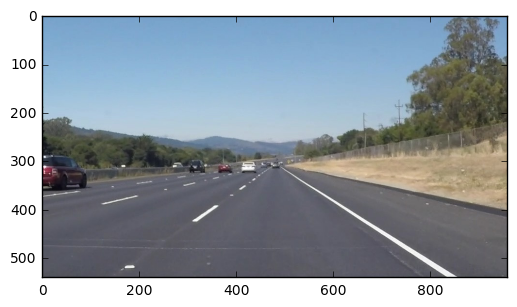

In [5]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [16]:
import matplotlib.image as mpimg
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

image1 = mpimg.imread('test_images/solidWhiteCurve.jpg')
image2 = mpimg.imread('test_images/solidWhiteRight.jpg')
image3 = mpimg.imread('test_images/solidYellowCurve.jpg')
image4 = mpimg.imread('test_images/solidYellowCurve2.jpg')
image5 = mpimg.imread('test_images/solidYellowLeft.jpg')
image6 = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
    

run your solution on all test_images and make copies into the test_images directory).

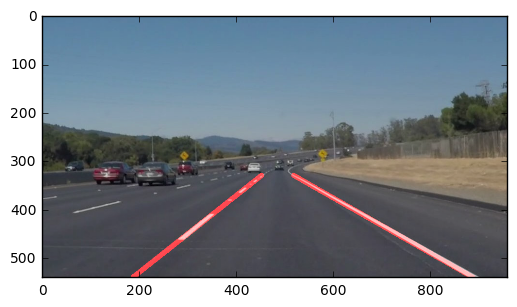

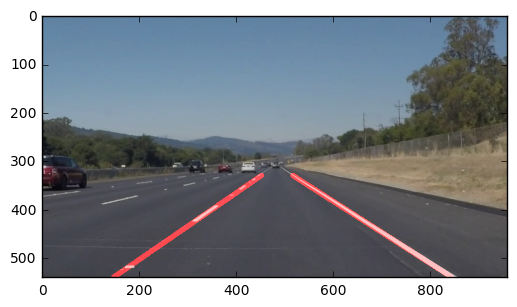

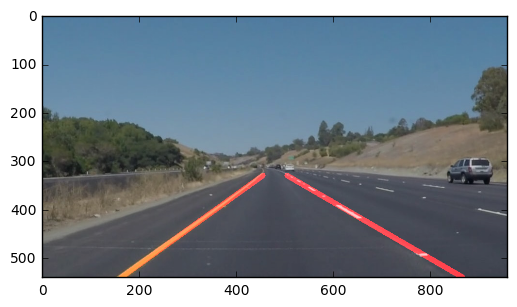

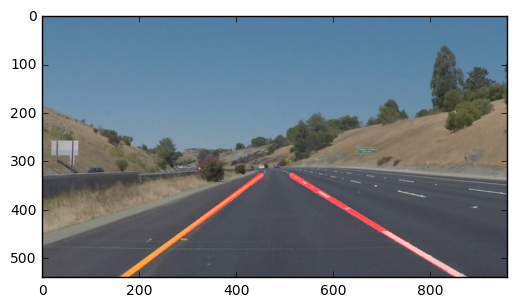

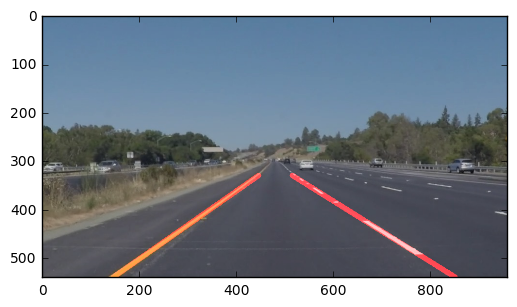

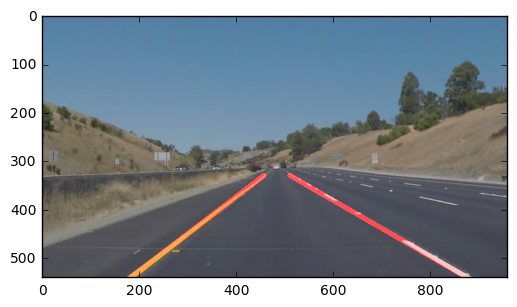

In [5]:
# Get it right on images first

#Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

#Import 6 images
image1 = mpimg.imread('test_images/solidWhiteCurve.jpg')
image2 = mpimg.imread('test_images/solidWhiteRight.jpg')
image3 = mpimg.imread('test_images/solidYellowCurve.jpg')
image4 = mpimg.imread('test_images/solidYellowCurve2.jpg')
image5 = mpimg.imread('test_images/solidYellowLeft.jpg')
image6 = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

#Create array
imgarray = [image1, image2, image3, image4, image5, image6]

#Refactor code to iterate
def process_image(image):
    #Create a grayscale image to detect lines of any color
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 5 # Carried over from the quiz exercise
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    
    # Define our parameters for Canny and run it
    low_threshold = 50 # Carried over from the quiz exercise, empirically works
    high_threshold = 151 # Carried over from the quiz exercise, empirically works
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   
    
    # This time we are defining a four sided polygon to mask
    # Coordinates are eye-balled and empirically whittled down
    # Opportunity to optimize but ultimately a function of camera type and position
    imshape = image.shape
    vertices = np.array([[(45,imshape[0]),(470, 325), (490, 325), ((imshape[1]-20),imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    
    #Define your parameters for the Hough Transform
    rho = 1
    theta = np.pi/180
    threshold = 15 #1
    min_line_length = 40 #10
    max_line_gap = 20 #1
    
    # Make a blank the same size as our image to draw on
    line_image = np.copy(image)*0 
    
    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
    
    # Function to draw single lines instead of segments over the lane lines
    # Summary of approach
    # Find the average slope of the left and right lane lines
    # Find the average (x,y) point on each line
    # Calculate the y-intercept of each line to get the equation y = mx + b
    # Use the y-intercept for each line to calculate the xmin and xmax values for that line
    # Hardcode the y values based on the camera placement
    
    # Create empty arrays to populate with left line and right line slope and coordinates, to find mean after
    leftslope = []
    rightslope = []
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    
    # Iterate through the array 'lines' (contains list of lists [x1, y1, x2, y2])
    for line in lines:
        for x1,y1,x2,y2 in line:
            # Calculate a slope of the line joining points (x1, y1) and (x2, y2)
            slope = (y2 - y1)/(x2 - x1)
            if slope > 0: #Right line, positive slope
                rightslope.append(slope)
                right_x.append(x1)
                right_x.append(x2)
                right_y.append(y1)
                right_y.append(y2)
            elif slope < 0: #Left line, negative slope
                leftslope.append(slope)
                left_x.append(x1)
                left_x.append(x2)
                left_y.append(y1)
                left_y.append(y2)
    
    # Calculate means with numpy.mean
    avgleftslope = np.mean(leftslope)
    avgrightslope = np.mean(rightslope)
    avgleft_x = np.mean(left_x)
    avgleft_y = np.mean(left_y)
    avgright_x = np.mean(right_x)
    avgright_y = np.mean(right_y)
    
    # Calculate y-intercept of left and right lines
    left_intercept = avgleft_y - avgleftslope * avgleft_x
    right_intercept = avgright_y - avgrightslope * avgright_x
    
    #Set ymax and ymin parameters
    ymax = 330
    ymin = 540
    
    # Left line
    # Use y-intercept to calculate xmin and xmax values for the Left Line, then draw the line
    x_left_min = (ymax-left_intercept)/avgleftslope
    x_left_max = (ymin-left_intercept)/avgleftslope
    cv2.line(line_image,(int(x_left_min),int(ymax)),(int(x_left_max),int(ymin)),(255,0,0),10)
    
    # Right line
    # Use y-intercept to calculate xmin and xmax values for the Right Line, then draw the line
    x_right_min = (ymax-right_intercept)/avgrightslope
    x_right_max = (ymin-right_intercept)/avgrightslope
    cv2.line(line_image,(int(x_right_min),int(ymax)),(int(x_right_max),int(ymin)),(255,0,0),10)
    
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 
    
    # Draw the lines on the edge image
    combo = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
    
    return combo

# Iterate through all 6 images and draw the lane lines
for image in imgarray:
    combo = process_image(image)
    plt.figure()
    plt.imshow(combo)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [22]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("solidWhiteRight.mp4"))

In [6]:
# Code for Video 1, solidWhiteRight.mp4

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Image processing function tested above
def process_image(image):
    #Create a grayscale image to detect lines of any color
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 5 # Carried over from the quiz exercise
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    
    # Define our parameters for Canny and run it
    low_threshold = 50 # Carried over from the quiz exercise, empirically works
    high_threshold = 151 # Carried over from the quiz exercise, empirically works
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   
    
    # This time we are defining a four sided polygon to mask
    # Coordinates are eye-balled and empirically whittled down
    # Opportunity to optimize but ultimately a function of camera type and position
    imshape = image.shape
    vertices = np.array([[(45,imshape[0]),(470, 325), (490, 325), ((imshape[1]-20),imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    
    #Define your parameters for the Hough Transform
    #Video works with rho = 1, tehta = np.pi/180, threshhold = 1, min_line_length = 10; max_line_gap = 1
    #Video works with rho = 1, tehta = np.pi/180, threshhold = 5, min_line_length = 10; max_line_gap = 1
    
    #Best -- above two cases will have lane lines occasionally cross into the road
    #Having a larger min_line_length parameter helps quality
    #Video works with rho = 1, tehta = np.pi/180, threshhold = 5, min_line_length = 20; max_line_gap = 1
    rho = 1
    theta = np.pi/180
    threshold = 5 
    min_line_length = 20 
    max_line_gap = 1
    
    # Make a blank the same size as our image to draw on
    line_image = np.copy(image)*0 
    
    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
    
    # Function to draw single lines instead of segments over the lane lines
    # Summary of approach
    # Find the average slope of the left and right lane lines
    # Find the average (x,y) point on each line
    # Calculate the y-intercept of each line to get the equation y = mx + b
    # Use the y-intercept for each line to calculate the xmin and xmax values for that line
    # Hardcode the y values based on the camera placement
    
    # Create empty arrays to populate with left line and right line slope and coordinates, to find mean after
    leftslope = []
    rightslope = []
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    
    # Iterate through the array 'lines' (contains list of lists [x1, y1, x2, y2])
    for line in lines:
        for x1,y1,x2,y2 in line:
            # Calculate a slope of the line joining points (x1, y1) and (x2, y2)
            slope = (y2 - y1)/(x2 - x1)
            if slope > 0: #Right line, positive slope
                rightslope.append(slope)
                right_x.append(x1)
                right_x.append(x2)
                right_y.append(y1)
                right_y.append(y2)
            elif slope < 0: #Left line, negative slope
                leftslope.append(slope)
                left_x.append(x1)
                left_x.append(x2)
                left_y.append(y1)
                left_y.append(y2)
    
    # Calculate means with numpy.mean
    avgleftslope = np.mean(leftslope)
    avgrightslope = np.mean(rightslope)
    avgleft_x = np.mean(left_x)
    avgleft_y = np.mean(left_y)
    avgright_x = np.mean(right_x)
    avgright_y = np.mean(right_y)
    
    # Calculate y-intercept of left and right lines
    left_intercept = avgleft_y - avgleftslope * avgleft_x
    right_intercept = avgright_y - avgrightslope * avgright_x
    
    #Set ymax and ymin parameters
    ymax = 330
    ymin = 540
    
    # Left line
    # Use y-intercept to calculate xmin and xmax values for the Left Line, then draw the line
    x_left_min = (ymax-left_intercept)/avgleftslope
    x_left_max = (ymin-left_intercept)/avgleftslope
    cv2.line(line_image,(int(x_left_min),int(ymax)),(int(x_left_max),int(ymin)),(255,0,0),10)
    
    # Right line
    # Use y-intercept to calculate xmin and xmax values for the Right Line, then draw the line
    x_right_min = (ymax-right_intercept)/avgrightslope
    x_right_max = (ymin-right_intercept)/avgrightslope
    cv2.line(line_image,(int(x_right_min),int(ymax)),(int(x_right_max),int(ymin)),(255,0,0),10)
    
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 
    
    # Draw the lines on the edge image
    combo = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
    
    return combo
# Code to write onto the video file
white_output = 'white_solution.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
# Embed video here
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video white_solution.mp4
[MoviePy] Writing video white_solution.mp4


100%|█████████▉| 221/222 [00:34<00:00,  4.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white_solution.mp4 

CPU times: user 31.3 s, sys: 1.98 s, total: 33.3 s
Wall time: 37.3 s


**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [7]:
# Solution for solidYellowLeft.mp4
# Identical to above, but some tinkering with the parameters
# Further optimization from filtering for slopes

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Function tested on images above
def process_image(image):
    #Create a grayscale image to detect lines of any color
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 5 # Carried over from the quiz exercise
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    
    # Define our parameters for Canny and run it
    low_threshold = 50 # Carried over from the quiz exercise, empirically works
    high_threshold = 151 # Carried over from the quiz exercise, empirically works
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   
    
    # This time we are defining a four sided polygon to mask
    # Coordinates are eye-balled and empirically whittled down
    # Opportunity to optimize but ultimately a function of camera type and position
    imshape = image.shape
    vertices = np.array([[(45,imshape[0]),(470, 325), (490, 325), ((imshape[1]-20),imshape[0])]], dtype=np.int32)
    #x1 at 460 and 465 does not work
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    
    #Define your parameters for the Hough Transform
    #Video works with rho = 1, theta = np.pi/180, threshhold = 1, min_line_length = 10; max_line_gap = 1
    
    #Best -- above two cases will have lane lines occasionally cross into the road
    #Having a larger min_line_length parameter helps quality
    #Video works with rho = 1, tehta = np.pi/180, threshhold = 1, min_line_length = 10; max_line_gap = 1
    #BEST Video works with rho = 1, tehta = np.pi/180, threshhold = 5, min_line_length = 10; max_line_gap = 1
    #Video works with rho = 1, tehta = np.pi/180, threshhold = 10, min_line_length = 10; max_line_gap = 1; 
    #   But video only plays 5ish seconds, internet problem? 
    #Video works with rho = 1, tehta = np.pi/180, threshhold = 10, min_line_length = 10; max_line_gap = 5;
    
    #Video DOES NOT work with rho = 1, tehta = np.pi/180, threshhold = 5, min_line_length = 15; max_line_gap = 1
    #Video DOES NOT work with rho = 1, tehta = np.pi/180, threshhold = 5, min_line_length = 12; max_line_gap = 1
    #Video DOES NOT work with rho = 1, tehta = np.pi/180, threshhold = 5, min_line_length = 10; max_line_gap = 10
    
    rho = 1
    theta = np.pi/180
    threshold = 5 
    min_line_length = 10
    max_line_gap = 1
    
    # Make a blank the same size as our image to draw on
    line_image = np.copy(image)*0 
    
    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
    
    # Function to draw single lines instead of segments over the lane lines
    # Summary of approach
    # Find the average slope of the left and right lane lines
    # Find the average (x,y) point on each line
    # Calculate the y-intercept of each line to get the equation y = mx + b
    # Use the y-intercept for each line to calculate the xmin and xmax values for that line
    # Hardcode the y values based on the camera placement
    
    # Create empty arrays to populate with left line and right line slope and coordinates, to find mean after
    leftslope = []
    rightslope = []
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    
    # Iterate through the array 'lines' (contains list of lists [x1, y1, x2, y2])
    for line in lines:
        for x1,y1,x2,y2 in line:
            # Calculate a slope of the line joining points (x1, y1) and (x2, y2)
            slope = (y2 - y1)/(x2 - x1)
            if slope > 0: #Right line, positive slope
                rightslope.append(slope)
                right_x.append(x1)
                right_x.append(x2)
                right_y.append(y1)
                right_y.append(y2)
            elif slope < 0: #Left line, negative slope
                leftslope.append(slope)
                left_x.append(x1)
                left_x.append(x2)
                left_y.append(y1)
                left_y.append(y2)
    
    # Calculate means with numpy.mean
    avgleftslope = np.mean(leftslope)
    avgrightslope = np.mean(rightslope)
    avgleft_x = np.mean(left_x)
    avgleft_y = np.mean(left_y)
    avgright_x = np.mean(right_x)
    avgright_y = np.mean(right_y)
    
    # Calculate y-intercept of left and right lines
    left_intercept = avgleft_y - avgleftslope * avgleft_x
    right_intercept = avgright_y - avgrightslope * avgright_x
    
    #Set ymax and ymin parameters
    ymax = 330
    ymin = 550
    
    # Left line
    # Use y-intercept to calculate xmin and xmax values for the Left Line, then draw the line
    x_left_min = (ymax-left_intercept)/avgleftslope
    x_left_max = (ymin-left_intercept)/avgleftslope
    cv2.line(line_image,(int(x_left_min),int(ymax)),(int(x_left_max),int(ymin)),(255,0,0),10)
    
    # Right line
    # Use y-intercept to calculate xmin and xmax values for the Right Line, then draw the line
    x_right_min = (ymax-right_intercept)/avgrightslope
    x_right_max = (ymin-right_intercept)/avgrightslope
    cv2.line(line_image,(int(x_right_min),int(ymax)),(int(x_right_max),int(ymin)),(255,0,0),10)
    
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 
    
    # Draw the lines on the edge image
    combo = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
    
    return combo

# Write the video
yellow_output = 'yellow_solution.mp4'
clip2 = VideoFileClip("solidYellowLeft.mp4")
yellow_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time yellow_clip.write_videofile(yellow_output, audio=False)

# Show the video in-line
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

[MoviePy] >>>> Building video yellow_solution.mp4
[MoviePy] Writing video yellow_solution.mp4


100%|█████████▉| 681/682 [01:58<00:00,  5.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow_solution.mp4 

CPU times: user 1min 50s, sys: 8.52 s, total: 1min 58s
Wall time: 2min 2s


## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

## Response
### Improvements
1) Use a polyfit function to extend the line segments instead of current point-intercept system
2) Optimize Hough transform parameters based on input vs hard coding and empirical testing
3) Optimize trapezoid region based on input instead hard coded
4) Biggest opportunity: Filter out large slope deltas in lane lines

The current algorithm fails by tweaking some of the Hough Transform parameters. Adding a filter to make sure cases without lines are handled separately rather than throwing an NaN error would be necessary in a driving environment. Weather conditions like snow would require testing and possibly separate filter conditions.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))